# DSC 80 - Discussion 04

### Due Date: Saturday October 22, 11:59 PM

**Discussions will be due by the end of the day on Saturday**

# Combining DataFrames, Permutation Testing & Data Visualization


In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
from IPython.display import HTML

In [2]:
# for formatting purposes
def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [3]:
# from discussion import *

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

# 1. Review: Combining DataFrames 

#### `merge()`

* Used to combine two (or more) dataframes on the basis of **values of common columns** (indices can also be used, use `left_index=True` and/or `right_index=True`).
    * If we are joining columns on columns, the DataFrame indexes will be ignored. 
    * If we are joining indexes on indexes or indexes on a column or columns, the index will be passed on.

* **`on`**: column or index level names to join on. 
    * These must be found in both DataFrames. 
    * If `on` is `None` and not merging on indexes then this defaults to the intersection of the columns in both DataFrames.

* **`how`**: specifies how to determine which keys are to be included in the resulting table. 
    * If a key (column name) combination does not appear in either the left or the right tables, the values in the joined table will be `np.NaN`.
    * Defaults to `inner`, joining will be performed on index. 

#### `concat()`

* Used to append one (or more) dataframes one below the other (or sideways, depending on whether the axis option is set to 0 or 1).
    * Useful if we have two or more data sets containing the same columns but different rows of data.
    * We can also the columns from one `Dataframe` to those of another `Dataframe`.

#### `join()`

* Used to merge two dataframes on the basis of the index; instead of using `merge()` with the option `left_index=True` we can use `join()`.
    * Join operation honors the object on which it is called: `a.join(b)` $ \neq $ `b.join(a)`.

<img src="imgs/join_types.jpg">

1. **Inner Join** – default behavior, only keep rows where the merge “on” value exists in both the left and right dataframes.
2. **Left Outer** – keep every row in the left dataframe.
    * Where there are missing values of the “on” variable in the right dataframe, add `np.NaN` values in the result.
3. **Right Join** – keep every row in the right dataframe. 
    * Where there are missing values of the “on” variable in the left column, add `np.NaN` values in the result.
4. **Outer Join** – returns all the rows from the left dataframe, all the rows from the right dataframe, and matches up rows where possible, with `NaNs` elsewhere.

We'll start with a simple example:

In [5]:
left = pd.DataFrame({'key': ['foo', 'bar'], 'val': [1, 2]}).set_index('key')
right = pd.DataFrame({'key': ['foo', 'bar'], 'val': [4, 5]}).set_index('key')

joined = left.join(right, lsuffix='_l', rsuffix='_r')

multi_table([left, right, joined])

Now let's try something a bit more complex:

In [6]:
df1_data = {
    'Year' : [2014, 2014, 2014, 2014, 2014],
    'Week' : ['A', 'B', 'B', 'C', 'D'],
    'Color' : ['Red', 'Red', 'Black', 'Red', 'Green'],
    'Val' : [50, 60, 70, 10, 20]
}

df1 = pd.DataFrame(df1_data).set_index('Week')

df2_data = {
    'Year' : [2014, 2014, 2014, 2014, 2014],
    'Week' : ['A', 'B', 'C', 'C', 'D'],
    'Color' : ['Black', 'Black', 'Green', 'Red', 'Red'],
    'Score' : [30, 100, 50, 20, 40]
}

df2 = pd.DataFrame(df2_data).set_index('Week')

multi_table([df1, df2])

,Year,Color,Val
Week,,,
A,2014,Red,50
B,2014,Red,60
B,2014,Black,70
C,2014,Red,10
D,2014,Green,20
,Year,Color,Score
Week,,,
A,2014,Black,30
B,2014,Black,100


In [7]:
# how many rows, how many columns?
df1.join(df2, lsuffix='_l', rsuffix = '_r')

,Year_l,Color_l,Val,Year_r,Color_r,Score
Week,,,,,,
A,2014,Red,50,2014,Black,30
B,2014,Red,60,2014,Black,100
B,2014,Black,70,2014,Black,100
C,2014,Red,10,2014,Green,50
C,2014,Red,10,2014,Red,20
D,2014,Green,20,2014,Red,40


In [8]:
# will this be any different?
df2.join(df1, lsuffix='_l', rsuffix = '_r')

,Year_l,Color_l,Score,Year_r,Color_r,Val
Week,,,,,,
A,2014,Black,30,2014,Red,50
B,2014,Black,100,2014,Red,60
B,2014,Black,100,2014,Black,70
C,2014,Green,50,2014,Red,10
C,2014,Red,20,2014,Red,10
D,2014,Red,40,2014,Green,20


# 2. Review: Permutation Testing

### Hypothesis testing

- In "vanilla" hypothesis testing, we are given a **single** observed sample, and are asked to make an assumption as to how it came to be.
    - This assumption is the **null hypothesis**.
    - This assumption must be a **probability model**, since we use it to generate new data.
- We simulate data under the null hypothesis to answer the question, **if this assumption is true, how likely is the given observation?**

### Permutation testing

* **Given two observed samples, are they fundamentally different, or could they have been generated by the same process?**
* In a permutation test, we decide whether two **fixed** random samples come from the same distribution.
- Unlike in the previous hypothesis testing examples, when conducting a permutation test, you do not know **what distribution** generated your two samples!


## Revisit: Birth weight example 👶

### Birth weight and Maternal Age

- Is there a significant difference in the weights of babies born to mothers who belong to certain weight categories?
- We have 3 groups:
    - Babies whose mothers belonged to age group 15-25
    - Babies whose mothers belonged to age group 25-35
    - Babies whose mothers belonged to age group 35-45
- In each group, the relevant attribute is the birth weight of the baby. 

In [9]:
# Kaiser dataset, 70s 
import os
baby_fp = os.path.join('data', 'baby1.csv')
baby = pd.read_csv(baby_fp)
baby.head()
# baby['Maternal Age'].max()

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False


In [10]:
mother_age_and_birthweight = baby[['Maternal Age', 'Birth Weight']]
mother_age_and_birthweight.head()

,Maternal Age,Birth Weight
0,27,120
1,33,113
2,28,128
3,23,108
4,25,136


### Exploratory data analysis

How many babies are in each group?

In [11]:
# Data binning
bins = [15,25,35,45]
group_names = ['15-25','25-35','35-45']
mother_age_and_birthweight['Age Bracket'] = pd.cut(mother_age_and_birthweight['Maternal Age'],bins,labels=group_names)
mother_age_and_birthweight.head()

/tmp/nix-shell.ogu57a/nix-shell.TGcENb/nix-shell.kPHpLY/nix-shell.H1buwP/nix-shell.HR75rY/ipykernel_1137/4268142971.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mother_age_and_birthweight['Age Bracket'] = pd.cut(mother_age_and_birthweight['Maternal Age'],bins,labels=group_names)


,Maternal Age,Birth Weight,Age Bracket
0,27,120,25-35
1,33,113,25-35
2,28,128,25-35
3,23,108,15-25
4,25,136,15-25


What is the average birth weight within each group?

In [12]:
mother_age_and_birthweight.groupby('Age Bracket')[['Birth Weight']].mean()

,Birth Weight
Age Bracket,
15-25,118.503861
25-35,120.354839
35-45,119.710938


Note that 16 ounces are in 1 pound, so the above weights are ~7-8 pounds.

### Visualizing birth weight distributions

- Below, we draw the distribution of birth weights, separated by mother's Age group.
- The histograms appear to be different, but is the difference possible **due to random chance** or is there a significant difference in the two distributions?

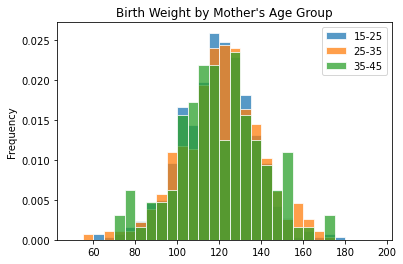

In [13]:
title = "Birth Weight by Mother's Age Group"

(
    mother_age_and_birthweight
    .groupby('Age Bracket')['Birth Weight']
    .plot(kind='hist', density=True, legend=True,
          ec='w', bins=np.arange(50, 200, 5), alpha=0.75,
          title=title)
);    

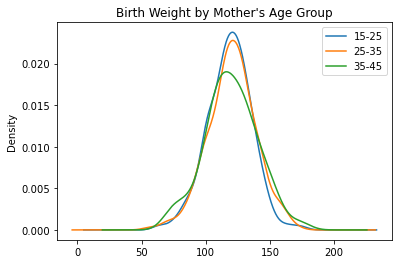

In [14]:
(
    mother_age_and_birthweight
    .groupby('Age Bracket')['Birth Weight']
    .plot(kind='kde', legend=True,
          title=title)
);    

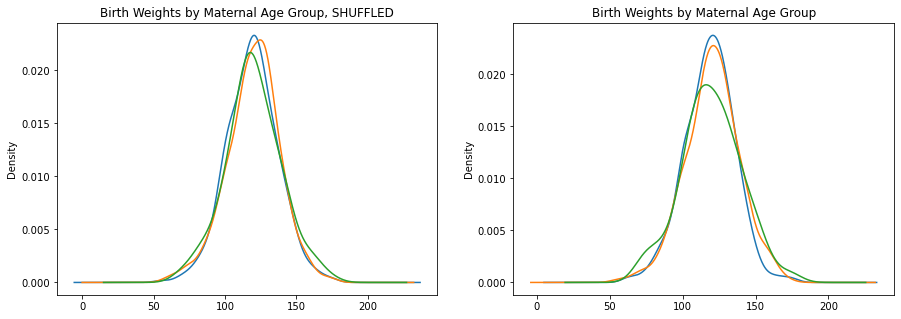

In [15]:
from matplotlib import pyplot as plt
shuffled_weights = (
    mother_age_and_birthweight['Birth Weight']
    .sample(frac=1)
    .reset_index(drop=True) # Question: What will happen if we do not reset the index?
)

original_and_shuffled = (
    mother_age_and_birthweight
    .assign(**{'Shuffled Birth Weight': shuffled_weights})
)


original_and_shuffled.head(10)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

title = 'Birth Weights by Maternal Age Group, SHUFFLED'
original_and_shuffled.groupby('Age Bracket')['Shuffled Birth Weight'].plot(kind='kde', title=title, ax=axes[0])

title = 'Birth Weights by Maternal Age Group'
original_and_shuffled.groupby('Age Bracket')['Birth Weight'].plot(kind='kde', title=title, ax=axes[1]);

In [16]:
observed_difference = (
    mother_age_and_birthweight
    .groupby('Age Bracket')['Birth Weight']
    .mean()
    .diff()
    .iloc[-1]
)

observed_difference

-0.6439012096774235

# 3. Plotting in `pandas`

## is as easy as `.plot()`

* `Series.plot()` plots a column.

In [17]:
data = pd.read_csv('data/data1.csv')

In [18]:
data.head()

,id,x,z0,z1,z2,z3
0,3,0.0000,0.000000,0.000000,-0.000000,0.273816
1,3,0.1001,-0.102628,0.001595,0.052832,-0.487302
2,3,0.2002,-0.223206,0.006378,-0.198124,-0.844929
3,2,0.3003,-0.484955,0.014347,0.126451,-0.357906
4,2,0.4004,0.350514,0.025499,0.439444,0.602113


In [19]:
# select a column from data
z0 = data['z0']
z0.head()

0    0.000000
1   -0.102628
2   -0.223206
3   -0.484955
4    0.350514
Name: z0, dtype: float64

* Use a line plot to plot numeric data.
* `data.plot()` plots a line plot by default.
    - The x-axis is the index by default
    - Can be called out using the key-word argument `x`.

<AxesSubplot:>

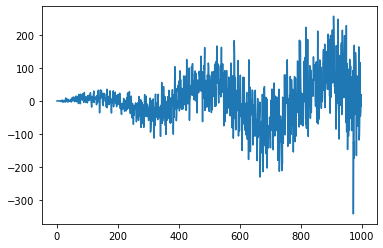

In [20]:
# index is [0...1000]
z0.plot()

In [21]:
# set index to plot correct x-axis
z0 = data.set_index('x').loc[:, 'z0']
z0.head()

x
0.0000    0.000000
0.1001   -0.102628
0.2002   -0.223206
0.3003   -0.484955
0.4004    0.350514
Name: z0, dtype: float64

<AxesSubplot:xlabel='x'>

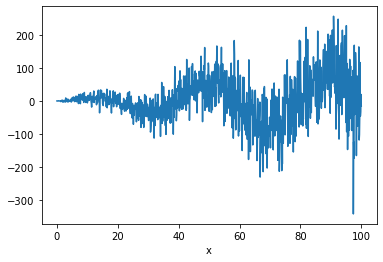

In [22]:
z0.plot()

<AxesSubplot:xlabel='x'>

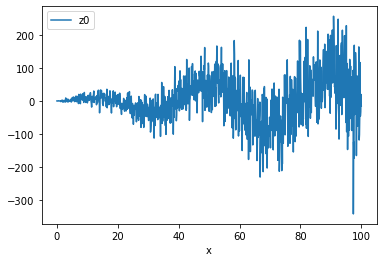

In [23]:
# set x-axis using a keyword argument
data.plot(x='x', y='z0')

### Plotting (quantitative) empirical distributions in Pandas

* Use the key-word argument `kind`
```
kind : str
    - 'hist' : histogram
    - 'box' : boxplot
    - 'kde' : Kernel Density Estimation plot
    ...
```
* The `hist` keyword by default uses 10 bins, and returns the *count* of observations within those bins.
    - use `density=True` to return a histogram whose area is normalized to 1.

<AxesSubplot:ylabel='Frequency'>

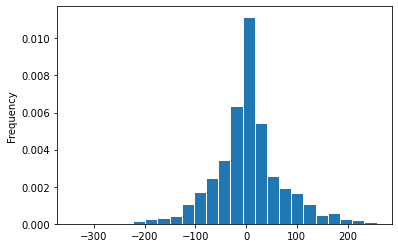

In [24]:
# histogram of z0 values; 
# 25 bins.
# density = normalized histogram

z0.plot(kind='hist', bins=25, density=True, ec='w')

<AxesSubplot:ylabel='Density'>

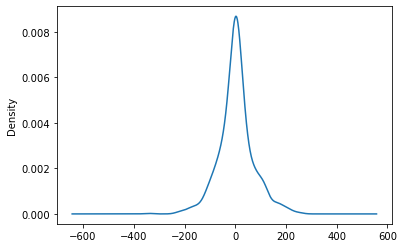

In [25]:
# kernel density estimate of the distribution
# smooth approximation of the empirical distribution

z0.plot(kind='kde')

<AxesSubplot:>

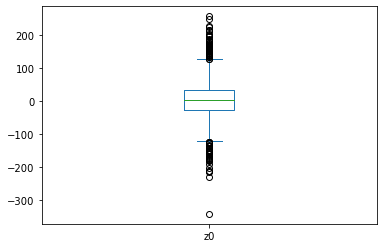

In [26]:
z0.plot(kind='box')

---

## Practice Problems

**Question 1**

Like in Discussion-03, You are given two seperate dataframes: `mlb_2017` and `mlb_2018`. Both dataframes contain statistics for the 2017 and 2018 baseball seasons respectively. Your job is two combine these two dataframes into one using the following guidelines:

* The dataframe you return should be indexed by team name (`Tm`).
* The dataframe you return should include columns `#Bat`, `BatAge`, `R/G`, `G` from `mlb_2017` and `mlb_2018`.
* Use the suffixes `_prev` and `_curr` to differentiate between statistics from both seasons.
* The dataframe you return should have all rows from `mlb_2018` irrespective of the team name `Tm`.

Create a function `specific_combined_seasons` that returns, as a tuple, the following:

* The combined dataframe described above.
* The highest average `R/G` of the 2017 and 2018 seasons combined.

In [27]:
def specific_combined_seasons(df1, df2):
    """
    Create a function that return, as a tuple, a dataframe combining
    the 2017 and 2018 MLB seasons as per the consitions specified as 
    well as the highest average R/G combining both the seasons.

    :Example:
    >>> mlb_2017 = pd.read_csv(os.path.join('data','mlb_2017.txt'))
    >>> mlb_2018 = pd.read_csv(os.path.join('data','mlb_2018.txt'))
    >>> result = combined_seasons(mlb_2017, mlb_2018)
    >>> result[0].shape
    (30, 8)
    >>> result[1] in result[0].index
    True
    """
    # BEGIN SOLUTION
    df_combined = df1.join(df2,how = 'right',lsuffix='_prev', rsuffix='_curr').loc[:,['#Bat_prev', 'BatAge_prev', 'R/G_prev', 'G_prev','#Bat_curr', 'BatAge_curr', 'R/G_curr', 'G_curr']]
    rg_avg_max = df_combined.filter(regex='R/G').mean(axis=1).max()
    
    return (df_combined, rg_avg_max)
    # END SOLUTION

In [28]:
# read in the following .txt files
mlb_2017 = pd.read_csv(os.path.join('data','mlb_2017.txt'))
mlb_2018 = pd.read_csv(os.path.join('data','mlb_2018.txt'))

multi_table([mlb_2017.head(), mlb_2018.head()])

,Tm,#Bat,BatAge,R/G,G,PA,AB,R,H,2B,...,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,LOB
0,ARI,45,28.3,5.01,162,6224,5525,812,1405,314,...,0.445,0.774,94,2457,106,54,39,27,44,1118
1,ATL,49,28.7,4.52,162,6216,5584,732,1467,289,...,0.412,0.738,92,2303,137,66,59,32,57,1127
2,BAL,50,28.6,4.59,162,6140,5650,743,1469,269,...,0.435,0.747,100,2458,138,50,10,37,12,1041
3,BOS,49,27.3,4.85,162,6338,5669,785,1461,302,...,0.407,0.736,92,2305,141,53,9,36,48,1134
4,CHC,47,27.1,5.07,162,6283,5496,822,1402,274,...,0.437,0.775,99,2403,134,82,48,32,54,1147
,Tm,#Bat,BatAge,R/G,G,PA,AB,R,H,2B,...,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,LOB
0,ARI,49,29.2,4.28,162,6157,5460,693,1283,259,...,0.397,0.707,85,2170,110,52,38,45,36,1086
1,ATL,58,27.3,4.69,162,6251,5582,759,1433,314,...,0.417,0.742,99,2330,99,66,49,43,53,1143
2,BAL,56,28.4,3.84,162,6034,5507,622,1317,242,...,0.391,0.689,90,2153,132,57,13,35,19,1027
3,BOS,44,27.7,5.41,162,6302,5623,876,1509,355,...,0.453,0.792,112,2550,130,55,7,48,38,1124


In [29]:
# don't change this cell -- it is needed for the tests to work
mlb_2017 = pd.read_csv(os.path.join('data','mlb_2017.txt'))
mlb_2018 = pd.read_csv(os.path.join('data','mlb_2018.txt'))
q1_out = specific_combined_seasons(mlb_2017, mlb_2018)

In [30]:
""" # BEGIN TEST CONFIG
points: 2
failure_message: 'doctest: shape'
""" # END TEST CONFIG
q1_out[0].shape == (30, 8)

True

In [31]:
""" # BEGIN TEST CONFIG
points: 1
failure_message: 'doctest: NaN count'
""" # END TEST CONFIG
q1_out[0].isna().sum().sum() == 16

True

In [32]:
""" # BEGIN TEST CONFIG
points: 2
failure_message: 'doctest: columns'
""" # END TEST CONFIG
all([(('_prev' in x) or ('_curr' in x)) for x in q1_out[0]])

True

In [33]:
""" # BEGIN TEST CONFIG
points: 1
failure_message: 'doctest: max average R/G incorrect'
""" # END TEST CONFIG
q1_out[1] == 5.13

True

**Question 2**

Plot the counts of meals in `tips` by day. Your plotting function, `plot_meal_by_day` should return an `matplotlib.axes._subplots.AxesSubplot` object; your plot should look like the plot below. 

Note: You don't need to have exact same colors, but the plot orientation, axis order, and title should match.

<img src="imgs/barh1.png" width="50%"/>

In [34]:
def plot_meal_by_day(tips):
    """
    Plots the counts of meals in tips by day.
    plot_meal_by_day returns a Figure
    object; your plot should look like the plot in the notebook.

    :Example:
    >>> tips = sns.load_dataset('tips')
    >>> fig = plot_meal_by_day(tips)
    >>> type(fig)
    <class 'matplotlib.figure.Figure'>
    """
    fig = plt.figure()
    # BEGIN SOLUTION
    ax = (
        tips['day']
        .value_counts()
        .sort_index()
        .plot(kind='barh', title='Counts of meals by day')
    )
    # END SOLUTION
    return fig


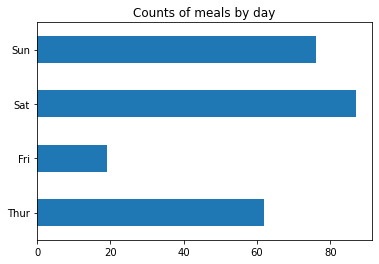

In [35]:
# don't change this cell -- it is needed for the tests to work
tips = sns.load_dataset('tips')
q1_fig = plot_meal_by_day(tips)

In [36]:
""" # BEGIN TEST CONFIG
points: 2
failure_message: 'doctest'
""" # END TEST CONFIG
isinstance(q1_fig, matplotlib.figure.Figure)

True

In [37]:
""" # BEGIN TEST CONFIG
points: 1
failure_message: 'need correct title'
""" # END TEST CONFIG
q1_fig.get_axes()[0].get_title()

'Counts of meals by day'

In [38]:
""" # BEGIN TEST CONFIG
points: 2
failure_message: 'y-axis sorted and labeled correctly?'
""" # END TEST CONFIG
[str(x.get_text()) for x in q1_fig.get_axes()[0].get_yticklabels()]

['Thur', 'Fri', 'Sat', 'Sun']

## Congratulations! You're done!

* Submit your `.py` file to Gradescope. Note that you only need to submit the `.py` file; this notebook should not be uploaded. Make sure that all of your work is in the `.py` file and not here by running the doctests: `python -m doctest discussion.py`.